Here, we want to know the model with the best explanatory power, compared to the rest.

## Requirements

```bash

mamba create -n acnets_bambi
mamba activate acnets_bambi
mamba install bambi ipykernel seaborn watermark
```

In [9]:
import bambi
import arviz as az
import xarray as xr
import re
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
INPUT_MODEL_NAME = 'connectivities_classifier-SVML1_measure-accuracy_top-10_cv-100x4fold'
OUTPUT_MODEL_NAME = f'{INPUT_MODEL_NAME}_bambi-1000draws'

In [11]:
results = xr.open_dataset(f'models/{INPUT_MODEL_NAME}.nc').load()

split_score_cols = [c for c in list(results.keys()) if re.match(r'split\d+_test_score', c)]
grid_cv_results = results[split_score_cols + ['rank_test_score', 'mean_test_score']].to_pandas()
grid_cv_results.index.name = 'label'
grid_cv_results = grid_cv_results.reset_index()

scores = grid_cv_results
# scores['label'] = scores['params'].apply(lambda p: _create_label(list(p.values())))
split_score_cols = [c for c in scores.columns if 'split' in c]
scores['test_score'] = scores[split_score_cols].apply(lambda x: list(x), axis=1)
scores = scores.explode('test_score').reset_index(drop=True)
scores = scores.sort_values('rank_test_score', ascending=False)
scores['label'] = scores['label'].apply(lambda x: x.replace('partial correlation', 'partial_correlation'))

scores[['atlas','kind']] = scores['label'].apply(lambda x: x.split(' ')).apply(pd.Series)
scores = scores[['atlas', 'kind', 'test_score']]

In [ ]:
def cleanup_label(label):
    label = label.replace('dosenbach2010', 'Dosenbach2010')
    label = label.replace('gordon2014_2mm', 'Gordon2014')
    label = label.replace('difumo_64_2mm', 'DiFuMo64')
    label = label.replace(', ',' : ')
    label=label.replace('kind', 'metric')
    return label

scores['kind'] = scores['kind'].apply(cleanup_label)
scores['atlas'] = scores['atlas'].apply(cleanup_label)

kind_cats=['covariance', 'tangent', 'correlation', 'partial_correlation','precision']
atlas_cats=["DiFuMo64", "Dosenbach2010", "Gordon2014"]
scores['atlas'] = scores['atlas'].astype('category').cat.reorder_categories(atlas_cats)
scores['kind'] = scores['kind'].astype('category').cat.reorder_categories(kind_cats)

scores['atlas'] = scores['atlas'].cat.as_ordered()
scores['kind'] = scores['kind'].cat.as_ordered()

In [12]:
model = bambi.Model('test_score ~ 0 + atlas * kind', scores)
fitted = model.fit(tune=1000, draws=2000, init='adapt_diag')

fitted.to_netcdf(f'outputs/model_comparison/{OUTPUT_MODEL_NAME}.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [atlas, kind, atlas:kind, test_score_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 42 seconds.


'outputs/model_comparison/connectivities_classifier-SVML1_measure-accuracy_top-10_cv-100x4fold_bambi-1000draws.nc'

## Part 2: Visualization

In [281]:
fitted = az.data.inference_data.InferenceData.from_netcdf(f'outputs/model_comparison/{OUTPUT_MODEL_NAME}.nc')

az.summary(fitted).sort_values('mean', ascending=False).to_csv(f'outputs/model_comparison/summary_{OUTPUT_MODEL_NAME}.csv')

# DEBUG plot using arviz
# az.plot_trace(fitted, legend=True)
# plt.tight_layout()
# plt.show()

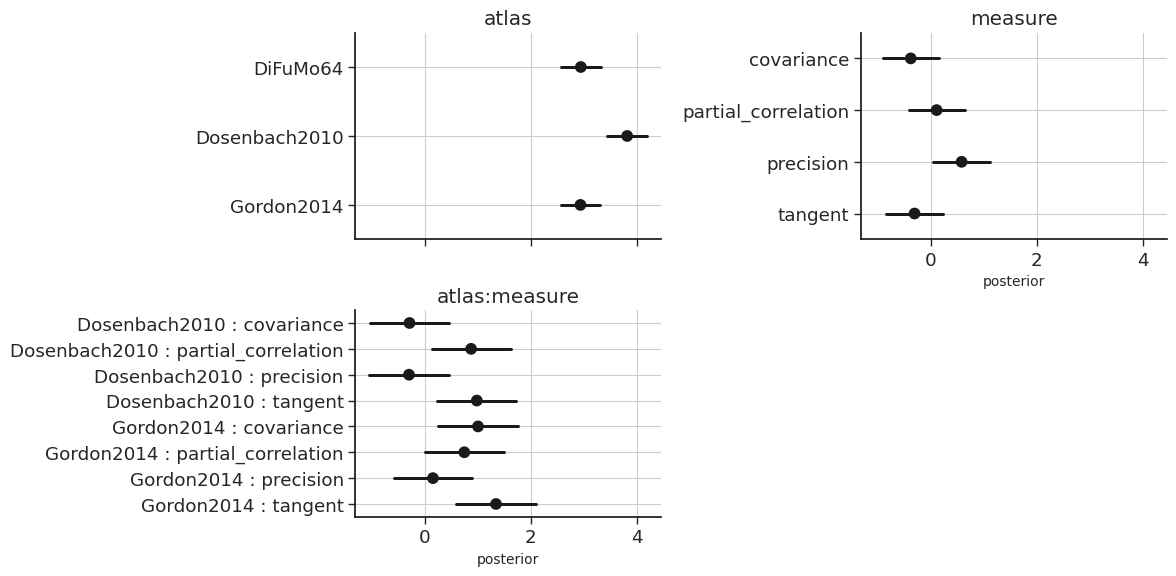

In [280]:
posteriors = []
for v in fitted['posterior'].data_vars:
    if 'test_score_sigma' in v:
        continue
    posterior = fitted['posterior'][v].to_dataframe().reset_index()
    posterior['parameter'] = v
    posterior['variable'] = posterior[f'{v}_dim']
    posterior['posterior'] = posterior[v]
    posterior = posterior[['parameter', 'variable', 'posterior']].copy()
    posteriors.append(posterior)


posteriors = pd.concat(posteriors)

import seaborn as sns
sns.set('paper', 'ticks', font_scale=1.5, rc={
    'xtick.bottom': True,
    'ytick.left': True,
    'axes.edgecolor': 'k',
    'axes.linewidth': 1.25,
    'axes.grid': True
})

def hdi_errorbar(**kwargs):
    az.summary(fitted, fmt='wide').loc['atlas[difumo_64_2mm]']['hdi_3%']
    print(kwargs)

g = sns.catplot(data=posteriors,
            y='variable',
            x='posterior',
            col='parameter',
            sharey=False,
            join=False,
            sharex=True,
            scale=1.2,
            col_wrap=2,
            color='k',
            errorbar=('sd', 3), capsize=0,
            kind='point',
            height=3, aspect=2,
)

g.axes[0].yaxis.grid(True)
g.axes[1].yaxis.grid(True)
g.axes[2].yaxis.grid(True)

# g.set_xticklabels(fontsize=10)
g.set_titles(template='{col_name}')
g.set_axis_labels('posterior', '', fontsize=10)
plt.tight_layout()
plt.savefig(f'outputs/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
%reload_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Dec 07 2022

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.6.0

re               : 2.2.1
bambi            : 0.9.1
pandas           : 1.5.2
seaborn          : 0.12.1
sys              : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
xarray           : 2022.11.0
matplotlib_inline: 0.1.6
matplotlib       : 3.6.2
arviz            : 0.14.0

Watermark: 2.3.1

